# Статистический анализ данных
###  3 поток, 2 когорта
#### Друзык Роман Богданович
*Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.*

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st


***

## Откроем файл с данными и изучим общую информацию.

In [2]:
pd.set_option('display.max_columns', 50)
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

*Начнем последовательную предобработку данных. Подготовим каждый набор данных к дальнейшему анализу.*
***

###    Посмотрим на набор calls

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


*Проверим на пропуски*

In [4]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

*Проверим на дубликаты*

In [5]:
calls.duplicated().sum()

0

*Проверим количество уникальных user_id*

In [6]:
calls.user_id.nunique()

492

***В данном наборе данных посмотрим распределение значений по столбцу duration***

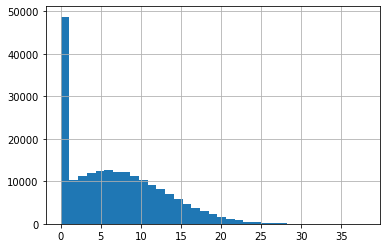

In [7]:
calls.duration.hist(bins=35)

Видим что очень большое количество значений попало в нулевое значение.
Предполагаем, что билинг тарифицировал короткие звонки (до 1 секунды) как нулевые, но мы знаем что оператор связи "Мегалайн" округляет любой звонок в большую сторону, в частности все сверхкороткие звонки должны быть округлены до 1 минуты.
Поступим таким образом, что заменим все 0 на 1, а так же округлим все длительности звонков в большую сторону, с точностью до 1 минуты.
Поменяем тип с вещественного на целочисленное в столбце duration.

In [8]:
#Меняем 0 на 1
calls['duration'] = calls['duration'].replace(0, 1)

In [9]:
#Округляем всё до целых в большую сторону
calls.duration = calls.duration.apply(math.ceil)

#Меняем тип данных на целочисленный
calls.duration = calls.duration.astype('int')

#Меняем колонку с датой на datetime
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m')

#Добавим в набор данных отдельными столбцами месяц и год
calls['month'] = calls['call_date'].dt.month
calls['year'] = calls['call_date'].dt.year

***

###     Посмотрим на набор internet

In [10]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


*Проверим на пропуски*

In [11]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

*Проверим на дубликаты*

In [12]:
internet.duplicated().sum()

0

*Проверим количество уникальных user_id*

In [13]:
internet.user_id.nunique()

497

**В данном наборе данных посмотрим распределение значений по столбцу mb_used**

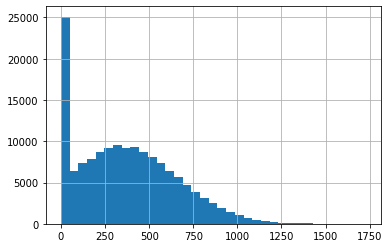

In [14]:
internet.mb_used.hist(bins=35)

Видим что большое количество значений попало в 0, никак предобрабатывать данный выпад не будем. Предполагаем, что, действительно, большое количество человек не пользуется интернетом, хотя сама сессия устанавливается, поэтому у нее есть идентификатор.
Столбец mb_used переведем в целочисленное с округлением до большего, а так же поменяем формат на datetime у session_date

In [15]:
#Округляем всё до целых в большую сторону
internet.mb_used = internet.mb_used.apply(math.ceil)

#Меняем тип данных на целочисленный
internet.mb_used = internet.mb_used.astype('int')

#Меняем колонку с датой на datetime
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m')

#Добавим в набор данных отдельными столбцами месяц и год
internet['month'] = internet['session_date'].dt.month
internet['year'] = internet['session_date'].dt.year

***

###     Посмотрим на набор messages

In [16]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


*Проверим на пропуски*

In [17]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

*Проверим на дубликаты*

In [18]:
messages.duplicated().sum()

0

*Проверим количество уникальных user_id*

In [19]:
messages.user_id.nunique()

426

*Приведем столбец message_date к формату datetime*

In [20]:
#Меняем колонку с датой на datetime
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m')

#Добавим в набор данных отдельными столбцами месяц и год
messages['month'] = messages['message_date'].dt.month
messages['year'] = messages['message_date'].dt.year

***       

###     Посмотрим на набор users

In [21]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


*Проверим на дубликаты*

In [22]:
users.duplicated().sum()

0

*Проверим на пропуски*

In [23]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

*Проверим количество уникальных user_id*

In [24]:
users.user_id.nunique()

500

***Видим пропуски в столбце churn_date. Это означает что абонент еще пользуется тарифом, ничего менять не будем.***

*Предобработаем форматы столбцов, дату приведем к формату datetime.*

In [25]:
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m')
#Добавим в набор данных отдельными столбцами месяц и год
users['month'] = users['reg_date'].dt.month
users['year'] = users['reg_date'].dt.year
users['died_month'] = users['churn_date'].dt.month

*Посмотрим на получившийся набор*

In [26]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,year,died_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,NaN
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,2018,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,2018,NaN
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,2018,NaN
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,2018,NaN


***

###    Посмотрим на набор tariffs

In [27]:
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [28]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


*Столбец mg_per_month_included переведем в гигабайты*

In [29]:
tariffs.mg_per_month_included = tariffs.mg_per_month_included / 1024
tariffs.mg_per_month_included = tariffs.mg_per_month_included.astype('int')

*Переименуем столбец*

In [30]:
tariffs.rename(columns={'mg_per_month_included' : 'gb_per_month_included', 'tariff_name' : 'tariff'}, inplace=True)

*В данных tarrifs всё прекрасно, предобрабатывать нечего*

### Вывод:

1. После предобработки входящих данных было выяснено, что имееются большое количество 0 в данных по голосовым вызовам, которые мы объяснили сверхкороткими звонками, которые билинг тарифицировал как нулевые, но мы округляем эти нули на 1, так как по условиям оператора, вызов любой длительности тарифицируем в большую сторону до минуты.
2. В данных по траффику так же имеется большое количество нулевых значений, но в данном случае мы можем это объяснить тем, что мобильный телефон установил сессию, но абонент не пользовался траффиком.
3. Мы увидели что данные предоставленны по 500 абонентам (набор users), но количество уникальных user_id в данных с сообщениями, звонками и траффиком меньше 500. Данный факт можно объяснить, что не каждый абонент пользуется всем перечнем услуг оператора (кто-то не использовал звонки, интернет или сообщения)

***

***

##     Объединение  данных в единную структуру и дополнение данных

Все таблицы у нас пересекаются по значению user_id, для удобства дальнейшего анализа соберем единную структуру данных.
Так же мы ожидаем в суммарной таблице обнаружить пропуски, которые необходимо будет заполнить.

***

*Сгруппируем наши данные о совершенных звонках по user_id и month*

In [31]:
calls_users = calls.pivot_table(index=('user_id','month'), 
                                values='duration', 
                                aggfunc='sum', 
                                fill_value=0).fillna(0).reset_index()
calls_users.head()

,user_id,month,duration
0,1000,5,164
1,1000,6,187
2,1000,7,346
3,1000,8,418
4,1000,9,478


***

*Сгруппируем наши данные о траффике по user_id и month*

In [32]:
internet_users = internet.pivot_table(index=('user_id','month'),
                                      values='mb_used', 
                                      aggfunc='sum',
                                      fill_value=0).fillna(0).reset_index()
internet_users.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


*Конвертируем значения из Мб в Гб с округлением до большего*

In [33]:
#Напишем функцию для конвертации
def mb_per_gb(value):
    if value>0:
        return math.ceil(value / 1024)
    else: 
        return 0

In [34]:
#Применим функцию
internet_users.mb_used = internet_users.mb_used.apply(mb_per_gb)

In [35]:
internet_users.head()

,user_id,month,mb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


***

*Сгруппируем наши данные о сообщениях по user_id и month*

In [36]:
messages_users = messages.pivot_table(index=('user_id', 'month'),
                                      values='message_date', 
                                      aggfunc='count',
                                      fill_value=0).fillna(0).reset_index()
messages_users.head()

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


***

*Добавим в нашу таблицу users информацию о параметрах тарифа, для удобства проведения расчетов*

In [37]:
users_tariffs = users.merge(tariffs, on='tariff', how='left')

In [81]:
users_tariffs.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,start_month,year,died_month,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,NaN,1000,30,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,2018,NaN,50,15,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,2018,NaN,50,15,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,2018,NaN,1000,30,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,2018,NaN,1000,30,3000,1950,150,1,1


*Переименуем столбец month, чтобы при последующем объединении он не пересекался со столбцами month*

In [39]:
users_tariffs.rename(columns={'month' : 'start_month'}, inplace=True)

In [40]:
users_tariffs.user_id.nunique()

500

***

*Добавим в суммарную таблицу данные о совершенных звонках*

In [41]:
total = users_tariffs.merge(calls_users, on='user_id', how='left').fillna(0)

In [42]:
#Проверим что мы не потеряли ни одного абонента
total.user_id.nunique()

500

***

*Добавим в суммарную таблицу данные об использованном трафике*

In [43]:
total = total.merge(internet_users, on=['user_id', 'month'], how='left').fillna(0)
total.shape

(3182, 21)

In [44]:
#Проверим что мы не потеряли ни одного абонента
total.user_id.nunique()

500

***

*Добавим в суммарную таблицу данные об отправленных сообщениях*

In [45]:
total = total.merge(messages_users, on=['user_id', 'month'], how='left').fillna(0)
total.shape

(3182, 22)

In [46]:
#Проверим что мы не потеряли ни одного абонента
total.user_id.nunique()

500

***

*Посмотрим на получившуюся таблицу*

In [47]:
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,start_month,year,died_month,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,5.0,164.0,3.0,22.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,6.0,187.0,23.0,60.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,7.0,346.0,14.0,75.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,8.0,418.0,14.0,81.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,9.0,478.0,15.0,57.0


*В данную таблицу нам необходимо добавить доход компании с абонента, за каждый месяц пользования. Для этих целей напишем функцию*

In [48]:
def monthly_revenue_per_user(row):

    #Посчитаем перерасходы, если перерасхода нет, то вернем 0, иначе модуль разницы
    overlimit_minutes = row['minutes_included'] - row['duration']
    overlimit_traffic = row['gb_per_month_included'] - row['mb_used']
    overlimit_messages = row['messages_included'] - row['message_date']
    
    if overlimit_minutes>=0:
        overlimit_minutes = 0
    else:
        overlimit_minutes = abs(overlimit_minutes)
        
    if overlimit_traffic>=0:
        overlimit_traffic = 0
    else:
        overlimit_traffic = abs(overlimit_traffic)
        
    if overlimit_messages>=0:
        overlimit_messages = 0
    else:
        overlimit_messages = abs(overlimit_messages)
#------------------------------------------------------------------------------------

    # Посчитаем доход с абонента в месяц, обязательно учтем с какого и до какого месяца клиент был абонентом, 
    #либо остается им до сих пор
    if (row['month']>=row['start_month'] and row['died_month']==0) or \
    (row['died_month']>=row['month']>=row['start_month']):
        revenue = row['rub_monthly_fee'] + \
        overlimit_minutes * row['rub_per_minute'] + \
        overlimit_traffic * row['rub_per_gb'] + \
        overlimit_messages * row['rub_per_message']
    else:
        revenue = 0
    return revenue

In [49]:
total['monthly_revenue'] = total.apply(monthly_revenue_per_user, axis=1)
total.shape

(3182, 23)

In [50]:
#Проверим что мы не потеряли ни одного абонента
total.user_id.nunique()

500

*Посмотрим на финальную таблицу*

In [83]:
total.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,start_month,year,died_month,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date,monthly_revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,5.0,164.0,3.0,22.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,0.0,1000,30,3000,1950,150,1,1,6.0,187.0,23.0,60.0,1950.0


### Вывод

Объеденили данные из исходных таблиц в единную структур и подготовили их для дальнейшего анализа.
Проверили, что все абонеты у нас учтены и никого по пути не потеряли.
Посчитали доходность с каждого абонента в месяц и добавили данные к сумарной таблице, так же посчитали уммарное количество записей в таблице.

***

***

## Анализ данных

#### *Визуализируем наши данные, посмотрим на разные поведенческие модели наших абонентов*

*Сгруппируем наши данные и подготовим их для анализа.*

In [52]:
#Соберем в одну таблицу данные средних потребления услуг в разрезе по месяцам для тарифа Smart
smart = total\
                .query("tariff=='smart' and monthly_revenue>0")\
                .pivot_table(index='month', \
                             values=['duration', 'mb_used', 'message_date', 'monthly_revenue'], \
                             aggfunc=['mean', 'sum'])\
                .reset_index()

In [53]:
#Соберем в одну таблицу данные средних потребления услуг в разрезе по месяцам для тарифа Ultra
ultra = total\
                .query("tariff=='ultra' and monthly_revenue>0")\
                .pivot_table(index='month', \
                             values=['duration', 'mb_used', 'message_date', 'monthly_revenue'], \
                             aggfunc=['mean', 'sum'])\
                .reset_index()

***

#### *Посчитаем дисперсию, стандартные отклонения и средние количества наших параметров по абонентам на разных тарифах*

*Для звонков*

In [54]:
print('---------------------------------------------------------------------')
print('Среднее количество совершенных звонков в месяц на тарифе SMART:{:.2f}'.format(smart[('mean', 'duration')].mean()))
print('Среднее количество совершенных звонков в месяц на тарифе ULTRA:{:.2f}'.format(ultra[('mean', 'duration')].mean()))
print('---------------------------------------------------------------------')
print('Стандартное отклонение по звонкам в месяц на тарифе SMART:{:.2f}'.format(np.std(smart[('mean', 'duration')])))
print('Стандартное отклонение по звонкам в месяц на тарифе ULTRA:{:.2f}'.format(np.std(ultra[('mean', 'duration')])))
print('---------------------------------------------------------------------')
print('Дисперсия по звонкам в месяц на тарифе SMART:{:.2f}'.format(np.var(smart[('mean', 'duration')])))
print('Дисперсия по звонкам в месяц на тарифе ULTRA:{:.2f}'.format(np.var(ultra[('mean', 'duration')])))
print('---------------------------------------------------------------------')

---------------------------------------------------------------------
Среднее количество совершенных звонков в месяц на тарифе SMART:398.24
Среднее количество совершенных звонков в месяц на тарифе ULTRA:525.07
---------------------------------------------------------------------
Стандартное отклонение по звонкам в месяц на тарифе SMART:71.62
Стандартное отклонение по звонкам в месяц на тарифе ULTRA:83.35
---------------------------------------------------------------------
Дисперсия по звонкам в месяц на тарифе SMART:5129.35
Дисперсия по звонкам в месяц на тарифе ULTRA:6947.08
---------------------------------------------------------------------


***

*Для трафика*

In [55]:
print('---------------------------------------------------------------------')
print('Среднее количество трафика в месяц на тарифе SMART:{:.2f}'.format(smart[('mean', 'mb_used')].mean()))
print('Среднее количество трафика в месяц на тарифе ULTRA:{:.2f}'.format(ultra[('mean', 'mb_used')].mean()))
print('---------------------------------------------------------------------')
print('Стандартное отклонение по трафику в месяц на тарифе SMART:{:.2f}'.format(np.std(smart[('mean', 'mb_used')])))
print('Стандартное отклонение по трафику в месяц на тарифе ULTRA:{:.2f}'.format(np.std(ultra[('mean', 'mb_used')])))
print('---------------------------------------------------------------------')
print('Дисперсия по трафику в месяц на тарифе SMART:{:.2f}'.format(np.var(smart[('mean', 'mb_used')])))
print('Дисперсия по трафику в месяц на тарифе ULTRA:{:.2f}'.format(np.var(ultra[('mean', 'mb_used')])))
print('---------------------------------------------------------------------')

---------------------------------------------------------------------
Среднее количество трафика в месяц на тарифе SMART:15.23
Среднее количество трафика в месяц на тарифе ULTRA:18.34
---------------------------------------------------------------------
Стандартное отклонение по трафику в месяц на тарифе SMART:2.53
Стандартное отклонение по трафику в месяц на тарифе ULTRA:2.76
---------------------------------------------------------------------
Дисперсия по трафику в месяц на тарифе SMART:6.39
Дисперсия по трафику в месяц на тарифе ULTRA:7.64
---------------------------------------------------------------------


***

*Для сообщений*

In [56]:
print('---------------------------------------------------------------------')
print('Среднее количество сообщений в месяц на тарифе SMART:{:.2f}'.format(smart[('mean', 'message_date')].mean()))
print('Среднее количество сообщений в месяц на тарифе ULTRA:{:.2f}'.format(ultra[('mean', 'message_date')].mean()))
print('---------------------------------------------------------------------')
print('Стандартное отклонение по сообщениям в месяц на тарифе SMART:{:.2f}'.format(np.std(smart[('mean', 'message_date')])))
print('Стандартное отклонение по сообщениям в месяц на тарифе ULTRA:{:.2f}'.format(np.std(ultra[('mean', 'message_date')])))
print('---------------------------------------------------------------------')
print('Дисперсия по сообщениям в месяц на тарифе SMART:{:.2f}'.format(np.var(smart[('mean', 'message_date')])))
print('Дисперсия по сообщениям в месяц на тарифе ULTRA:{:.2f}'.format(np.var(ultra[('mean', 'message_date')])))
print('---------------------------------------------------------------------')

---------------------------------------------------------------------
Среднее количество сообщений в месяц на тарифе SMART:31.42
Среднее количество сообщений в месяц на тарифе ULTRA:43.49
---------------------------------------------------------------------
Стандартное отклонение по сообщениям в месяц на тарифе SMART:4.89
Стандартное отклонение по сообщениям в месяц на тарифе ULTRA:11.68
---------------------------------------------------------------------
Дисперсия по сообщениям в месяц на тарифе SMART:23.91
Дисперсия по сообщениям в месяц на тарифе ULTRA:136.48
---------------------------------------------------------------------


***

*Для дохода*

In [57]:
print('---------------------------------------------------------------------')
print('Среднее количество дохода в месяц на тарифе SMART:{:.2f}'.format(smart[('mean', 'monthly_revenue')].mean()))
print('Среднее количество дохода в месяц на тарифе ULTRA:{:.2f}'.format(ultra[('mean', 'monthly_revenue')].mean()))
print('---------------------------------------------------------------------')
print('Стандартное отклонение по доходу в месяц на тарифе SMART:{:.2f}'.format(np.std(smart[('mean', 'monthly_revenue')])))
print('Стандартное отклонение по доходу в месяц на тарифе ULTRA:{:.2f}'.format(np.std(ultra[('mean', 'monthly_revenue')])))
print('---------------------------------------------------------------------')
print('Дисперсия по доходу в месяц на тарифе SMART:{:.2f}'.format(np.var(smart[('mean', 'monthly_revenue')])))
print('Дисперсия по доходу в месяц на тарифе ULTRA:{:.2f}'.format(np.var(ultra[('mean', 'monthly_revenue')])))
print('---------------------------------------------------------------------')

---------------------------------------------------------------------
Среднее количество дохода в месяц на тарифе SMART:1198.93
Среднее количество дохода в месяц на тарифе ULTRA:2049.03
---------------------------------------------------------------------
Стандартное отклонение по доходу в месяц на тарифе SMART:236.47
Стандартное отклонение по доходу в месяц на тарифе ULTRA:55.18
---------------------------------------------------------------------
Дисперсия по доходу в месяц на тарифе SMART:55919.00
Дисперсия по доходу в месяц на тарифе ULTRA:3044.72
---------------------------------------------------------------------


***

##### *Посмотрим на распредление среднему количесту потраченных минут и по суммарному количеству потраченых минут всеми абонентами за месяц на разных тарифах*

*Распредление среднего количества потраченных минут по месяцам*

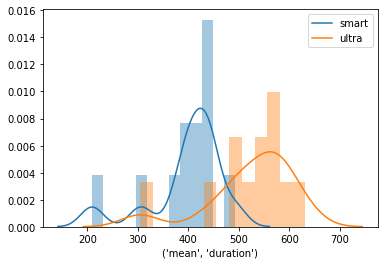

In [58]:
sns.distplot(smart[('mean', 'duration')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('mean', 'duration')], bins=13, kde_kws={"label": "ultra"})

*Суммарное количество потраченых минут всеми абонентами за месяц*

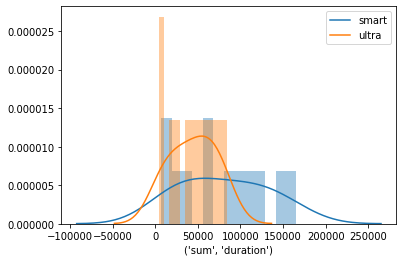

In [59]:
sns.distplot(smart[('sum', 'duration')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('sum', 'duration')], bins=13, kde_kws={"label": "ultra"})

*Посмотрим рост голосового трафика в разрезе по месяцам*

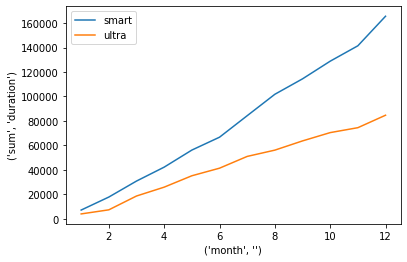

In [60]:
sns.lineplot(y=('sum', 'duration'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('sum', 'duration'), x=('month',''), data=ultra, label='ultra')

*Посмотрим как менялось среднее потребление минут по месяцам*

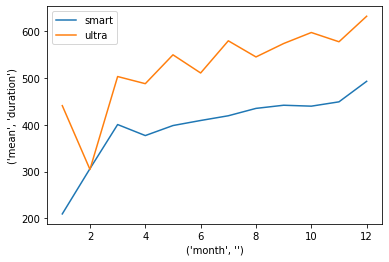

In [61]:
sns.lineplot(y=('mean', 'duration'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('mean', 'duration'), x=('month',''), data=ultra, label='ultra')

*Из данного распределения можно сделать вывод что формы распредления очень похожи. Абоненты обоих тарифов в основном укладываются в установленный пакет минут, но абоненты тарифа ultra сильно "недобирают".
Распределение у обоих тарифов похоже на нормальное, с выбросами слева.
За год голосовой трафик рос в линейной прогрессии - такой вид связан с тем, что мы рассматриваем только абонентов 1 года, количество которых росло в течении года.
Абоненты тарифа smart вносят больший вклад в рост голосового трафика.
Абоненты тармфа ultra в среднем разговаривают больше*

***

##### *Посмотрим на распредление среднему количесту потраченных гигабайтов на разных тарифах*

*Распредление среднего количества потраченных трафика по месяцам*

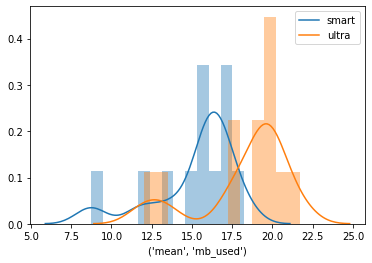

In [62]:
sns.distplot(smart[('mean', 'mb_used')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('mean', 'mb_used')], bins=13, kde_kws={"label": "ultra"})

*Суммарное количество потраченых гигабайт всеми абонентами за месяц*

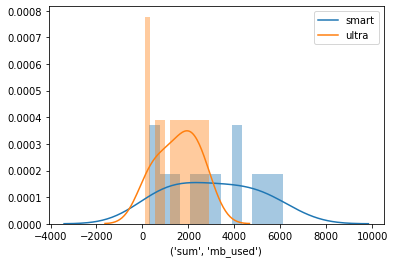

In [63]:
sns.distplot(smart[('sum', 'mb_used')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('sum', 'mb_used')], bins=13, kde_kws={"label": "ultra"})

*Посмотрим рост интернет-трафика в разрезе по месяцам*

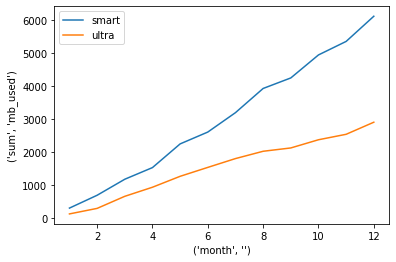

In [64]:
sns.lineplot(y=('sum', 'mb_used'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('sum', 'mb_used'), x=('month',''), data=ultra, label='ultra')

*Посмотрим как менялось среднее потребление трафика по месяцам*

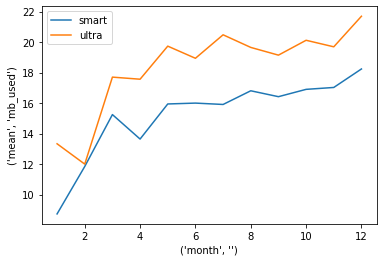

In [65]:
sns.lineplot(y=('mean', 'mb_used'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('mean', 'mb_used'), x=('month',''), data=ultra, label='ultra')

*Из данного распределения можно сделать вывод что формы распредления очень похожи. 
Абоненты тарифа smart в основной массе потребляют трафика больше, чем предоплачено тарифом, на тарифе ultra всё с точностью наоборот - не потребляют оплаченное количество траффика.
Распределение у обоих тарифов похоже на нормальное, с выбросами слева.
За год интернет-трафик рос в линейной прогрессии - такой вид связан с тем, что мы рассматриваем только абонентов 1 года, количество которых росло в течении года.
Абоненты тарифа smart вносят больший вклад в рост интернет-трафика.
Абоненты тармфа ultra в среднем качают данных больше*

***

##### *Посмотрим на распредление среднему количесту отправленных сообщений на разных тарифах*

*Распредление среднего количества сообщений по месяцам*

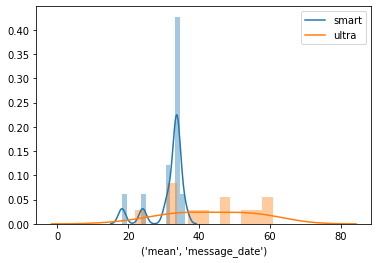

In [66]:
sns.distplot(smart[('mean', 'message_date')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('mean', 'message_date')], bins=13, kde_kws={"label": "ultra"})

*Суммарное количество потраченых сообщений всеми абонентами за месяц*

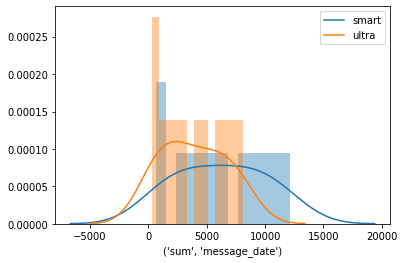

In [67]:
sns.distplot(smart[('sum', 'message_date')], bins=13, kde_kws={"label": "smart"})
sns.distplot(ultra[('sum', 'message_date')], bins=13, kde_kws={"label": "ultra"})

*Посмотрим рост количества отправленных сообщений в разрезе по месяцам*

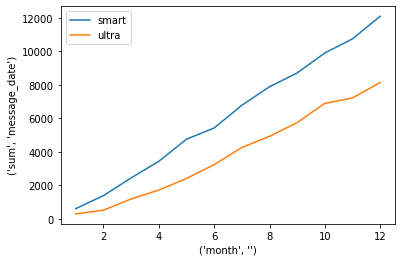

In [68]:
sns.lineplot(y=('sum', 'message_date'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('sum', 'message_date'), x=('month',''), data=ultra, label='ultra')

*Посмотрим как менялось среднее количество отправленных сообщений по месяцам*

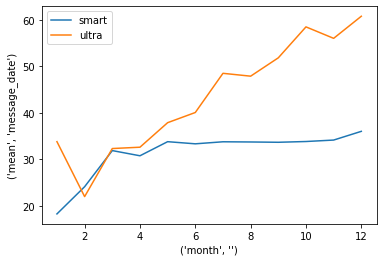

In [69]:
sns.lineplot(y=('mean', 'message_date'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('mean', 'message_date'), x=('month',''), data=ultra, label='ultra')

*Из данного анализа можно сделать вывод, что среднее количество отправленныз СМС на тарифе smart имеет ярко-выраженное среднее в районе 31, что соответствует 1 СМС в день. 
Суммарное количество отправленных сообщений на тарифе smart выше, чем на ultra - это можно объяснить большим количеством абонентов, в то же время среднее количество отправленных СМС в разрезе по месяцам, на тарифе ultra растет в линейной прогресси, когда на тарифе smart данный показатель стабилен и не меняется в течении года.*

***

##### *Посмотрим на распредление среднему количесту потраченных денег на разных тарифах*

*Распредление среднего дохода по месяцам*

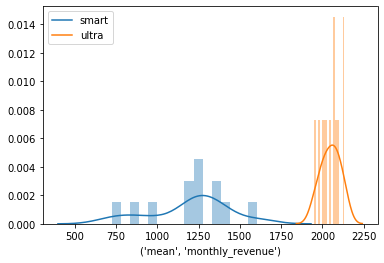

In [70]:
sns.distplot(smart[('mean', 'monthly_revenue')], bins=16, kde_kws={"label": "smart"})
sns.distplot(ultra[('mean', 'monthly_revenue')], bins=16, kde_kws={"label": "ultra"})

*Суммарное количество дохода всеми абонентами за месяц*

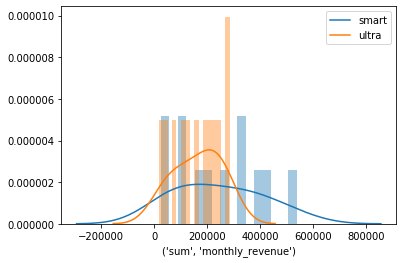

In [71]:
sns.distplot(smart[('sum', 'monthly_revenue')], bins=16, kde_kws={"label": "smart"})
sns.distplot(ultra[('sum', 'monthly_revenue')], bins=16, kde_kws={"label": "ultra"})

*Посмотрим рост дохода в разрезе по месяцам*

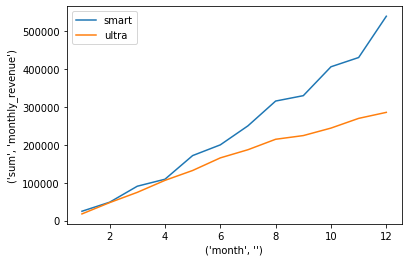

In [72]:
sns.lineplot(y=('sum', 'monthly_revenue'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('sum', 'monthly_revenue'), x=('month',''), data=ultra, label='ultra')

*Посмотрим как менялось средний доход по месяцам*

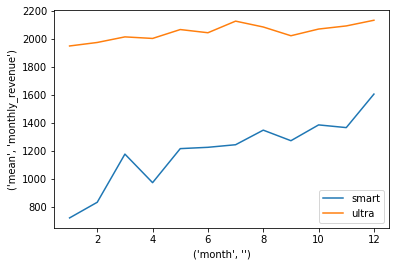

In [73]:
sns.lineplot(y=('mean', 'monthly_revenue'), x=('month',''), data=smart, label='smart')
sns.lineplot(y=('mean', 'monthly_revenue'), x=('month',''), data=ultra, label='ultra')

*По данному распределению видно структуру затрат абонентов на разных тарифах. Абоенеты тарифа ultra, в основном укладываются в месячную абонентскую плату, а абоненты на тарифе smart тратян на услуги связи в 2-3 раза больше, чем размер абонентской платы. Так же можем увидеть, что средняя выручка в разрезе*

### Вывод

По структуре трат абонентов двух тарифов, можно увидеть различную струтктуру потребления услуг.
В частности:
1. Абоненты тарифа ultra тратят голосового трафика больше, но в целом укладываются в предоплаченный пакет минут, чего нельзя сказать об абонентах тарифа smart.
2. Абоненты тарифа ultra тратя, интернет-трафика больше, но в целом укладываются в предоплаченный пакет гигабайтов, чего нельзя сказать об абонентах тарифа smart.
3. Абоненты тарифа ultra тратят сообщений больше, но в целом укладываются в предоплаченный пакет сообщений, что совпадает с поведением абонентов тарифа smart.
4. Среднее ARPU с абонента тарифа ultra больше (что предсказуемо), но в основной массе укладывается в месячную абонентскую плату. 
5. Среднее ARPU с абонета тарифа smart меньше, чем у абонентов тарифа ultra, но в 2-3 раза превышает месячную абонентскую плату.

***

***

## Проверка гипотез

### Сравнение средней выручки абонентов тарифа smart и ultra.

*Сформируем нулевую гипотезу:*

**H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

**H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова**


*Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей, нам необходимо взять две выборки и сравнить их между собой с помощью t-критерия Стьюдента.
Определим критический уровень значимости на уровне 5%*

In [74]:
#Выберем в отдельный массив все средние выручки на тарифе smart по каждому абоненту
mean_revenue_smart = total\
                .query("tariff=='smart'")\
                .pivot_table(index='user_id', \
                             values='monthly_revenue', \
                             aggfunc='mean')\
                .reset_index()

In [75]:
#Выберем в отдельный массив все средние выручки на тарифе ultra по каждому абоненту
mean_revenue_ultra = total\
                .query("tariff=='ultra'")\
                .pivot_table(index='user_id', \
                             values='monthly_revenue', \
                             aggfunc='mean')\
                .reset_index()

*Для проверки нулевой гипотезы используем метод ttest_ind*

In [76]:
alpha = .05
result = st.ttest_ind(mean_revenue_smart['monthly_revenue'], mean_revenue_ultra['monthly_revenue'], equal_var = False)
print('p-значение:', result.pvalue)
if (result.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.447966047834908e-29
Не получилось отвергнуть нулевую гипотезу


#### *Результат проверки:*

*При сравнении средней выручки абонентов тарифа smart и ultra, с использованием t-критерия Стюдента и критическим уровнем значимости 5%, можно предположить, что средняя выручка у абонентов разных тарифов различается*

***

### Сравнение средней выручки пользователей из Москвы пользователей из других регионов.

*Сформируем нулевую гипотезу:*

**H0 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

**H1 - средняя выручка пользователей из Москвы одинакова с выручкой пользователей из других регионов**

*Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей, нам необходимо взять две выборки и сравнить их между собой с помощью t-критерия Стьюдента.
Определим критический уровень значимости на уровне 5%*

In [1]:
#Выберем в отдельный массив все средние выручки на тарифе smart по каждому абоненту в Москве
mean_revenue_moscow = total\
                .query("city=='Москва'")\
                .pivot_table(index='user_id', \
                             values='monthly_revenue', \
                             aggfunc='mean')\
                .reset_index()

NameError: name 'total' is not defined

In [78]:
#Выберем в отдельный массив все средние выручки на тарифе smart по каждому абоненту в Москве
mean_revenue_regions = total\
                .query("city!='Москва'")\
                .pivot_table(index='user_id', \
                             values='monthly_revenue', \
                             aggfunc='mean')\
                .reset_index()

*Для проверки нулевой гипотезы используем метод ttest_ind*

In [79]:
alpha = .05
result = st.ttest_ind(mean_revenue_moscow['monthly_revenue'], mean_revenue_regions['monthly_revenue'], equal_var = False)
print('p-значение:', result.pvalue)
if (result.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6847502682471547
Отвергаем нулевую гипотезу


#### *Результат проверки:*

*При сравнении средней выручки абонентов города Москвы и регионов, с использованием t-критерия Стюджента и критическим уровнем значимости 5%, можно предположить, что средняя выручка у жителей регионов и Москвы не различается.*

***

***

### Общий вывод

*Мы провели полный анализ данных абонентов, их поведения, уровня потребления трафика (голос, трафик, сообщения).
Если мы определяем, что главный критерий для компании о приоритетности тарифа - суммарная выручка с данных абонентов на определнном тарифе, то мы можем сделать вывод что тариф smart более интересен компании.
Тариф smart является более массовым: хоть и ARPU на данном тарифе и ниже чем на ultra, но за счет количества абонентов, которые пользуются им, суммарный денежный поток выше.
Так же мы проверили гипотезу о разной средней выручке в столице и регионах - оказалось что значительной разницы нет*